<h1>Predicción del tráfico de bicicletas en Seattle con LR<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

Queremos predecir el número de bicicletas que atraviesan un puente de Seattle basándonos en el tiempo, la época del año y otras cosas. Partimos de un dataset con los datos de desplazamientos en bicicleta a través de ese lugar y los datos de una estación metereológica cercana. Es un caso especial en el que las características tienen un significado interpretable, pero no es lo habitual.

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample

Descargamos los datos:

In [2]:
#!curl -o data/FremontBridge.csv https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD
#!curl -o data/BicycleWeather.csv https://share.cocalc.com/share/8b892baf91f98d0cf6172b872c8ad6694d0f7204/PythonDataScienceHandbook/notebooks/data/BicycleWeather.csv

Cargamos los datos de ambos ficheros en sendos DataFrames de Pandas, y les echamos un primer vistazo:

In [3]:
counts = pd.read_csv('data/FremontBridge.csv', index_col='Date', parse_dates=True)
counts.head()

,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
Date,,
2019-02-28 23:00:00,5.0,6.0
2019-02-28 22:00:00,4.0,27.0
2019-02-28 21:00:00,16.0,32.0
2019-02-28 20:00:00,16.0,50.0
2019-02-28 19:00:00,39.0,59.0


In [4]:
weather = pd.read_csv('data/BicycleWeather.csv', index_col='DATE', parse_dates=True)
weather.head()

,STATION,STATION_NAME,PRCP,SNWD,SNOW,TMAX,TMIN,AWND,WDF2,WDF5,...,WT17,WT05,WT02,WT22,WT04,WT13,WT16,WT08,WT18,WT03
DATE,,,,,,,,,,,,,,,,,,,,,
2012-01-01,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,0,0,0,128,50,47,100,90,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999
2012-01-02,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,109,0,0,106,28,45,180,200,...,-9999,-9999,-9999,-9999,-9999,1,1,-9999,-9999,-9999
2012-01-03,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,8,0,0,117,72,23,180,170,...,-9999,-9999,-9999,-9999,-9999,-9999,1,-9999,-9999,-9999
2012-01-04,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,203,0,0,122,56,47,180,190,...,-9999,-9999,-9999,-9999,-9999,1,1,-9999,-9999,-9999
2012-01-05,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,13,0,0,89,28,61,200,220,...,-9999,-9999,-9999,-9999,-9999,-9999,1,-9999,-9999,-9999


Agrupamos el número de bicicletas por día y sumamos ambos sentidos:

In [5]:
daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']] # eliminamos el resto de columnas
daily.head()

,Total
Date,
2012-10-03,3521.0
2012-10-04,3475.0
2012-10-05,3148.0
2012-10-06,2006.0
2012-10-07,2142.0


Creamos columnas para el día de la semana, pensando que pueda variar el tránsito

In [6]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

También vamos a suponer que los días festivos pueden influir:

In [7]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)

Podemos pensar que las horas de luz influyen de alguna forma. Vamos a crear una función para calcularlas en función de la fecha y de la longitud/latitud:

In [8]:
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))

Vamos a jugar con las temperaturas (en 1/10 ºC; conversión a ºC) y las precipitaciones (en 1/10 mm; conversión a pulgadas). Añadimos un par de variables nuevas:

In [9]:
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])

Añadimos un contador de años transcurridos (con decimales), desde el primer día medido:

In [10]:
daily['annual'] = (daily.index - daily.index[0]).days / 365.

Observamos ahora la pinta del DataFrame:

In [11]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,13.35,1.0,0.000000
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,13.60,1.0,0.002740
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,15.30,1.0,0.005479
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,15.85,1.0,0.008219
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,15.85,1.0,0.010959


Procedemos directamente a eliminar las filas con algún valor NA:

In [12]:
daily.dropna(axis=0, how='any', inplace=True)

Separamos el dataset en las variables independientes por un lado, y la variable dependiente por otro:

In [13]:
column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual']
X = daily[column_names]
y = daily['Total']

Aplicamos el modelo a los datos de entrenamiento y predecimos para las mismas muestras de entrada (al ser lineal no importa).

In [14]:
model = LinearRegression(fit_intercept=False)
model.fit(X, y)
daily['predicted'] = model.predict(X)

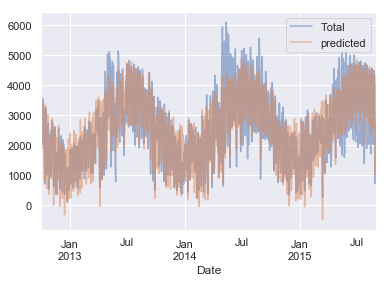

In [15]:
daily[['Total', 'predicted']].plot(alpha=0.5);

Observamos los coeficientes para cada variable, así como el error:

In [16]:
params = pd.Series(model.coef_, index=X.columns)

np.random.seed(1)
err = np.std([model.fit(*resample(X, y)).coef_ for i in range(1000)], 0)

print(pd.DataFrame({'effect': params.round(0), 'error': err.round(0)}))

              effect  error
Mon            505.0   86.0
Tue            610.0   83.0
Wed            593.0   83.0
Thu            482.0   85.0
Fri            178.0   81.0
Sat          -1103.0   80.0
Sun          -1134.0   83.0
holiday      -1187.0  163.0
daylight_hrs   129.0    9.0
PRCP          -665.0   62.0
dry day        548.0   33.0
Temp (C)        65.0    4.0
annual          27.0   18.0


A partir de esta información podemos ver que entre semana se coge más la bici que en los fines de semana o en vacaciones; más de lunes a jueves que los viernes. Cada hora de luz adicional supone 129 ± 9 bicicletas más, así como cada grado acarrea  65 ± 4 bicicletas. la lluvia en cambio supone un descenso del número. Anualmente observamos que el número crece, aunque poco.

El modelo seguramente está perdiendo información al aplicar regresión lineal (efectos no lineales de la temperatura o de la lluvia) así como podemos pensar en que nos falta información de entrada más fina (por ejemplo a qué horas hizo sol, se nubló o llovió). Hemos además ignorado la correlación entre variables (seguramente un lunes lluvioso influye en el martes, así como una secuencia de días lluviosos anterior a un sábado soleado). Hay mucho margen de mejora!